# Калибровка моделей по нерезидентам

In [1]:
import joblib
import sys
sys.path.append('..')
import os

import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier 

from sklearn.calibration import calibration_curve

In [2]:
RAW_DATA_PATH = os.path.join('..', 'data', 'raw', 'raw.csv')

BOOSTING_MODEL_PATH = os.path.join('..', 'models', 'req_amount', 'lgbm.pkl')
CALIBRATED__BOOSTING_MODEL_PATH = os.path.join('..', 'models', 'calibrated', 'calibrated_lgbm.pkl')

In [3]:
boosting_data = pd.read_csv(
    RAW_DATA_PATH,
    index_col='AppId',
    parse_dates=['dtstart', 'birthday'],
    usecols=[
        # origin
        'AppId',
        'dtstart',
        'birthday',
        'sex',
        'citizenshipid',
        'martialid',
        'dependents',
        'sitename',
        'DOC',
        'averagemonthlyincome',
        'requested_amount',

        # nbki
        'Days_since_last_credit',
        'Max_overdue',

        #equifax
        'Nb_delays_90plus_ever_eq',
        'CH_length_eq',
        'S_hare_active_credit',

        # megafon/mail
        'Score',
        'MatchingLevel',
        'LIFETIMEBINValueId',
        'INTEGRALSCOREValueId',

        '60_6mob',
    ]
)

boosting_data = boosting_data.query('dtstart < "2023-09-01"')
boosting_data['60_6mob'] = boosting_data['60_6mob'].apply(lambda x: 0 if str(x) == '0.0' else 1)  # Предобработка таргета

boosting_data = boosting_data.sort_values('dtstart')

boosting_data.head()

FileNotFoundError: [Errno 2] No such file or directory: '../data/raw/raw.csv'

In [4]:
# Out-of-time
train = boosting_data.query('"2021-08-01" <= dtstart < "2023-01-01"')
oot = boosting_data.query('"2023-01-01" <= dtstart < "2023-04-01"')
all_new = boosting_data.query('"2023-04-01" <= dtstart') # вызревшие 

print(
    f'Размер обучающей выборки {train.shape[0]} '
    f'(доля дефолтников {train["60_6mob"].mean():.2%}).\n'
    f'Размер OOT выборки {oot.shape[0]} '
    f'(доля дефолтников {oot["60_6mob"].mean():.2%}).\n'
    f'Размер Вызревшей выборки {all_new.shape[0]} '
    f'(доля дефолтников {all_new["60_6mob"].mean():.2%}).\n'
)

Размер обучающей выборки 12330 (доля дефолтников 23.58%).
Размер OOT выборки 1530 (доля дефолтников 18.04%).
Размер Вызревшей выборки 826 (доля дефолтников 18.04%).



In [5]:
# подгрузим веса моделей 
boosting_model = joblib.load(BOOSTING_MODEL_PATH)
calibrated_boosting = joblib.load(CALIBRATED__BOOSTING_MODEL_PATH)

/home/abdulvasiev/credit-line/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/abdulvasiev/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
# сохраним predict_proba модели бустинга
all_new['proba'] = boosting_model.predict_proba(all_new.drop(['60_6mob'],axis=1))[:,1]

/tmp/ipykernel_1753177/3667075754.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_new['proba'] = boosting_model.predict_proba(all_new.drop(['60_6mob'],axis=1))[:,1]


### ЛогРег на предиктах бустинга для калибровки 

In [7]:
lr_model = LogisticRegression()

In [8]:
lr_model.fit(all_new[['proba']], all_new['60_6mob'])

LogisticRegression()

In [9]:
y_prob_lr = lr_model.predict_proba(all_new[['proba']])[:,1] #predict_proba LR
y_prob_calibrated = calibrated_boosting.predict_proba(all_new.drop(['60_6mob'],axis=1))[:,1] #predict_proba Calibrated_Classifier_CV

In [10]:
prob_true_boosting, prob_pred_boosting = calibration_curve(all_new['60_6mob'], all_new['proba'], n_bins=10) # Boosting
prob_true_calibrated, prob_pred_calibrated = calibration_curve(all_new['60_6mob'], y_prob_calibrated, n_bins=10) # Calibrated Classifier
prob_true_lr, prob_pred_lr = calibration_curve(all_new['60_6mob'], y_prob_lr, n_bins=10) # LogReg

Логика построения графика: 
1) Cкорим пользователей, напротив каждого записивыем predict_proba
2) Сортируем по predict_proba
3) Разбиваем на 10 групп
4) Внутри каждой группы считаем среднюю предсказанную вероятность
5) Внутри каждой группы считаем процент всех дефолтников попавших в эту группу
6) По оси Х откладываем значения полученные из пункта 4, а по оси Y откладываем значения из пункта 5
7) Повторяем для остальных алгоритмов

Диагональная линия - идеальный вариант откалиброванной модели

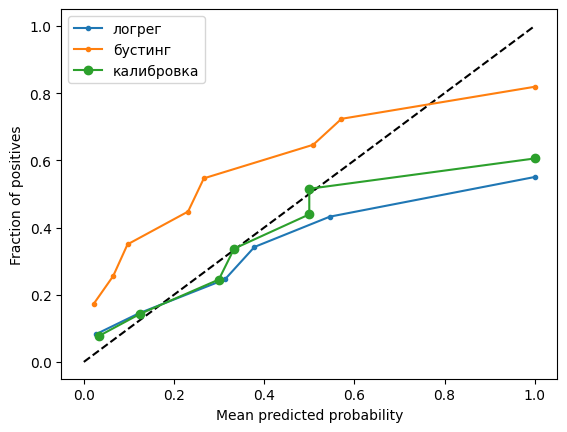

In [11]:
fig, ax = plt.subplots()

ax.plot([0, 1], [0, 1], linestyle='--', color='black')

ax.plot(prob_true_lr, prob_pred_lr, marker='.', label='логрег')
ax.plot(prob_true_boosting, prob_pred_boosting, marker='.', label='бустинг')
ax.plot(prob_true_calibrated, prob_pred_calibrated, marker='o', label='калибровка')  
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
ax.legend()
plt.show()

## Probability Calibration Trees
*https://www.youtube.com/watch?v=IL7sWMOazXQ*

1) Обучаем дерево решений по всем фичам на таргет дефолта (с глубиной 5 и 700 наблюдений в листе чтобы можно было строить на каждом листе логрег)
2) Получаем прогнозы бустинга сохраняем скоры
3) С помощью дерева решений разбиваем на группы которые получаются при обучении модели
4) Внтри каждого листа обучаем логрег на прогнозах бустинга

In [26]:
def transform(x):
    return np.log(x/(1-x))

In [27]:
def give_ece_data(preds,bins,y_valid):
    sorted_ind = np.argsort(preds)
    predicted_bins = [[] for _ in range(bins)]
    actual_counters = [[] for _ in range(bins)]
    counters = [[] for _ in range(bins)]
    index = 0
    length_array = len(sorted_ind)
    step = 1.*length_array//bins
    for _ in range(bins):
        current = int(step*index)
        next_ = int(step*(index+1))
        predicted_bins[index] = np.mean(preds[sorted_ind[current:next_]])
        actual_counters[index] = np.mean(y_valid[sorted_ind[current:next_]])
        counters[index] = len(y_valid[sorted_ind[current:next_]])
        index += 1
    return predicted_bins,actual_counters,counters

In [14]:
dt_X = boosting_model[0].transform(train.drop(['60_6mob'],axis=1))

In [15]:
dt_X.drop(['sitename'],axis=1,inplace=True) # удалим категориальный признак, чтобы не заниматься обработкой

In [16]:
tree_model = DecisionTreeClassifier(min_samples_leaf=700,max_depth=5)

In [17]:
tree_model.fit(dt_X,train['60_6mob']) # обучим неглубокое дерево

DecisionTreeClassifier(max_depth=5, min_samples_leaf=700)

In [18]:
dt_oot_X = boosting_model[0].transform(oot.drop(['60_6mob'],axis=1))
dt_new_X = boosting_model[0].transform(all_new.drop(['60_6mob'],axis=1))

In [19]:
dt_oot_X.drop(['sitename'],axis=1,inplace=True)
dt_new_X.drop(['sitename'],axis=1,inplace=True)

In [20]:
TREE = tree_model.tree_
indexes = TREE.apply(dt_oot_X.values.astype(np.float32))
predicts_from_boosting = boosting_model.predict_proba(oot.drop(['60_6mob'],axis=1))
predicts_from_boosting = predicts_from_boosting[:,1].reshape((-1,1))

In [21]:
# Обучим логрег на каждом листе

log_reg_dict = {}
nodes = np.unique(indexes)
model = LogisticRegression()
for node in nodes:
    model.fit(transform(predicts_from_boosting[indexes==node]),oot['60_6mob'][indexes==node])
    log_reg_dict[node] = model

In [22]:
indexes_test = TREE.apply(dt_new_X.values.astype(np.float32))
predicts_from_boosting_test = boosting_model.predict_proba(all_new.drop(['60_6mob'],axis=1))
predicts_from_boosting_test = predicts_from_boosting_test[:,1].reshape((-1,1))
predicts_calibrated = np.zeros_like(predicts_from_boosting_test)

In [23]:
for node in log_reg_dict.keys():
    predicts_calibrated[indexes_test==node] = log_reg_dict[node].predict_proba(transform(predicts_from_boosting_test[indexes_test==node]))[:,1].reshape((-1,1))

In [24]:
dt_prob_pred, dt_prob_true = calibration_curve(all_new['60_6mob'], predicts_calibrated, n_bins=10) 

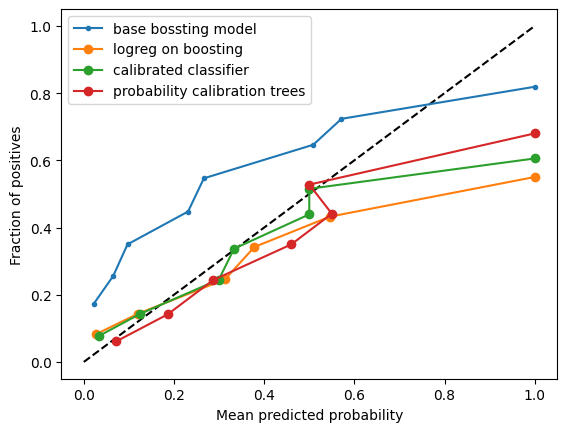

In [25]:
#добавим к графику калибровку на деревьях

fig, ax = plt.subplots()

ax.plot([0, 1], [0, 1], linestyle='--', color='black')

ax.plot(prob_true_boosting, prob_pred_boosting, marker='.', label='base bossting model')
ax.plot(prob_true_lr, prob_pred_lr, marker='o', label='logreg on boosting')
ax.plot(prob_true_calibrated, prob_pred_calibrated, marker='o', label='calibrated classifier')  
ax.plot(dt_prob_pred, dt_prob_true, marker='o', label='probability calibration trees')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
ax.legend()
plt.show()


### RegPlot

1) скорим пользователей
2) Сортируем по predict_proba
3) Разбиваем на 30 групп
4) Внутри каждой группы считаем среднюю предсказанную вероятность 
5) Внутри каждой группы считаем пропорцию дефолтников ко всем попавшим в эту группу
6) По оси Х откладываем значения полученные в пункте 4, а по оси Y откладываем значения из пункта 5
7) Повторяем для остальных алгоритмов

In [26]:
# Готовим данные для построения графика и расчета Expected Calibration Error (ECE)
# Для этого воспользуемся функцией give_ece_data
# Посчитаем ECE для логрега

bins = 30
predicted_bins,actual_counters,counters = give_ece_data(y_prob_lr.reshape((-1)),bins,all_new['60_6mob'].values)
lr_df = pd.DataFrame({'predicted':predicted_bins,'actual':actual_counters})

ece = 0
for i in range(bins):
    ece +=  counters[i]*np.abs((predicted_bins[i] - actual_counters[i]))
ece /= len(boosting_model.predict_proba(all_new.drop(['60_6mob'],axis=1))[:,1])
print(ece)

0.0670776450217051


In [27]:
# Посчитаем ECE для калибровки на деревьях

bins = 30
predicted_bins,actual_counters,counters = give_ece_data(predicts_calibrated.reshape((-1)),bins,all_new['60_6mob'].values)
check = pd.DataFrame({'predicted':predicted_bins,'actual':actual_counters})

ece = 0
for i in range(bins):
    ece +=  counters[i]*np.abs((predicted_bins[i] - actual_counters[i]))
ece /= len(boosting_model.predict_proba(all_new.drop(['60_6mob'],axis=1))[:,1])
print(ece)

0.06700842428957497


In [28]:
# Посчитаем ECE для калиброванного бустинга

bins = 30
predicted_bins,actual_counters,counters = give_ece_data(y_prob_calibrated.reshape((-1)),bins,all_new['60_6mob'].values)
calibrated_rf = pd.DataFrame({'predicted':predicted_bins,'actual':actual_counters})

ece = 0
for i in range(bins):
    ece +=  counters[i]*np.abs((predicted_bins[i] - actual_counters[i]))
ece /= len(boosting_model.predict_proba(all_new.drop(['60_6mob'],axis=1))[:,1])
print(ece)

0.053959255522949064


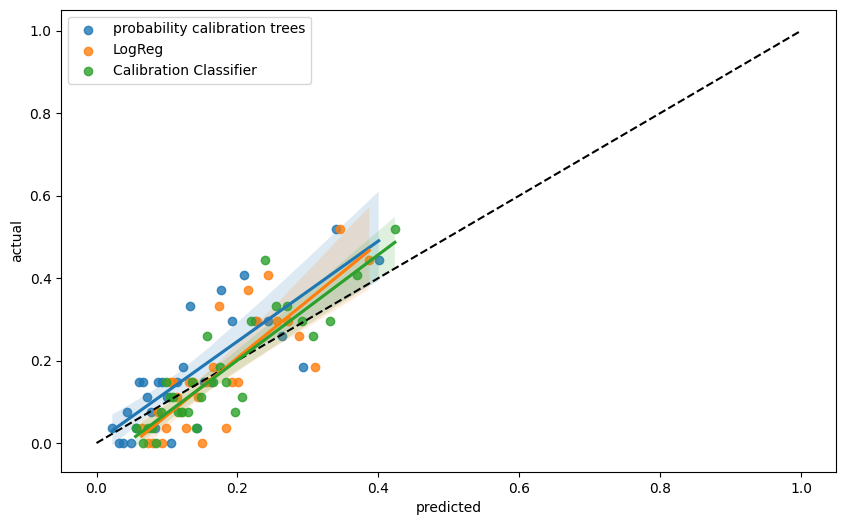

In [30]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot([0, 1], [0, 1], linestyle='--', color='black')
sns.regplot(x='predicted', y='actual', data=check, label='probability calibration trees')
sns.regplot(x='predicted', y='actual', data=lr_df, label='LogReg')
sns.regplot(x='predicted', y='actual', data=calibrated_rf, label='Calibration Classifier')
# ax.set(ylabel='y', xlabel='x')
ax.legend()
plt.show()

# Random Forrest

In [7]:
RF_MODEL_PATH = os.path.join('..', 'models', 'req_amount', 'rf.pkl')
CALIBRATED_RF_MODEL_PATH = os.path.join('..', 'models', 'calibrated', 'calibrated_rf.pkl')

In [8]:
rf_data = pd.read_csv(
    RAW_DATA_PATH,
    index_col='AppId',
    parse_dates=['dtstart', 'birthday'],
    usecols=[
        # origin
        'AppId',
        'dtstart',
        'birthday',
        'sex',
        'citizenshipid',
        'martialid',
        'dependents',
        'sitename',
        'DOC',
        'averagemonthlyincome',
        'requested_amount',
        
        # nbki
        'Days_since_last_credit',
        'Max_overdue',

        #equifax
        'Nb_delays_90plus_ever_eq',
        'CH_length_eq',
        'S_hare_active_credit',

        # megafon/mail
        'Score',
        'MatchingLevel',
        'LIFETIMEBINValueId',
        'INTEGRALSCOREValueId',

        '60_6mob',
    ]
)

rf_data = rf_data.query('dtstart < "2023-09-01"')
rf_data['60_6mob'] = rf_data['60_6mob'].apply(lambda x: 0 if str(x) == '0.0' else 1)  # Предобработка таргета

rf_data = rf_data.sort_values('dtstart')

rf_data.head()

,dtstart,sex,birthday,citizenshipid,martialid,dependents,sitename,DOC,averagemonthlyincome,Days_since_last_credit,Max_overdue,Nb_delays_90plus_ever_eq,CH_length_eq,S_hare_active_credit,Score,MatchingLevel,INTEGRALSCOREValueId,LIFETIMEBINValueId,60_6mob,requested_amount
AppId,,,,,,,,,,,,,,,,,,,,
617650,2019-09-26 13:19:00,2.0,1960-11-08,860,3.0,0,www.maximus.ru,2.0,10000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.064780,5.0,0,13454.0
620164,2019-09-27 11:13:00,1.0,1988-07-10,762,1.0,0,www.maximus.ru,1.0,45000,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.078340,5.0,0,19172.3
631492,2019-10-04 18:29:00,1.0,1989-02-14,762,2.0,1,www.megafon.ru,1.0,100000,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.134316,4.0,0,12453.7
637036,2019-10-08 20:50:00,1.0,1995-07-10,762,1.0,0,www.megafon.ru,NaN,60000,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.272594,1.0,0,23069.2
639263,2019-10-10 14:03:00,1.0,1990-10-30,762,2.0,1,www.megafon.ru,1.0,70000,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.097222,5.0,0,26940.9


In [9]:
# Out-of-time
train = rf_data.query('"2021-08-01" <= dtstart < "2023-01-01"')
oot = rf_data.query('"2023-01-01" <= dtstart < "2023-04-01"')
all_new = rf_data.query('"2023-04-01" <= dtstart') # вызревшие 

print(
    f'Размер обучающей выборки {train.shape[0]} '
    f'(доля дефолтников {train["60_6mob"].mean():.2%}).\n'
    f'Размер OOT выборки {oot.shape[0]} '
    f'(доля дефолтников {oot["60_6mob"].mean():.2%}).\n'
    f'Размер Вызревшей выборки {all_new.shape[0]} '
    f'(доля дефолтников {all_new["60_6mob"].mean():.2%}).\n'
)

Размер обучающей выборки 12330 (доля дефолтников 23.58%).
Размер OOT выборки 1530 (доля дефолтников 18.04%).
Размер Вызревшей выборки 826 (доля дефолтников 18.04%).



In [10]:
# подгрузим веса моделей 
rf_model = joblib.load(RF_MODEL_PATH)
calibrated_rf = joblib.load(CALIBRATED_RF_MODEL_PATH)

In [11]:
# сохраним predict_proba модели бустинга
all_new['proba'] = rf_model.predict_proba(all_new.drop(['60_6mob'],axis=1))[:,1]

/tmp/ipykernel_1753177/1201508679.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_new['proba'] = rf_model.predict_proba(all_new.drop(['60_6mob'],axis=1))[:,1]


In [12]:
lr_model = LogisticRegression()

In [13]:
lr_model.fit(all_new[['proba']], all_new['60_6mob'])

LogisticRegression()

In [14]:
y_prob_lr = lr_model.predict_proba(all_new[['proba']])[:,1] #predict_proba LR
y_prob_calibrated = calibrated_rf.predict_proba(all_new.drop(['60_6mob'],axis=1))[:,1] #predict_proba Calibrated_Classifier_CV

In [15]:
prob_true_rf, prob_pred_rf = calibration_curve(all_new['60_6mob'], all_new['proba'], n_bins=10) # Boosting
prob_true_calibrated, prob_pred_calibrated = calibration_curve(all_new['60_6mob'], y_prob_calibrated, n_bins=10) # Calibrated Classifier
prob_true_lr, prob_pred_lr = calibration_curve(all_new['60_6mob'], y_prob_lr, n_bins=10) # LogReg

Логика построения графика: 
1) Cкорим пользователей, напротив каждого записивыем predict_proba
2) Сортируем по predict_proba
3) Разбиваем на 10 групп
4) Внутри каждой группы считаем среднюю предсказанную вероятность
5) Внутри каждой группы считаем процент всех дефолтников попавших в эту группу
6) По оси Х откладываем значения полученные из пункта 4, а по оси Y откладываем значения из пункта 5
7) Повторяем для остальных алгоритмов

Диагональная линия - идеальный вариант откалиброванной модели

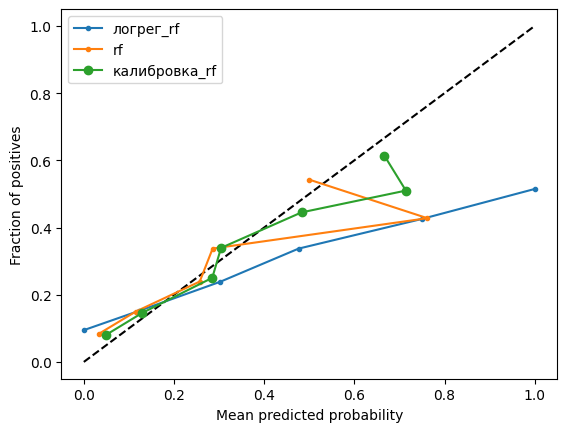

In [17]:
fig, ax = plt.subplots()

ax.plot([0, 1], [0, 1], linestyle='--', color='black')

ax.plot(prob_true_lr, prob_pred_lr, marker='.', label='логрег_rf')
ax.plot(prob_true_rf, prob_pred_rf, marker='.', label='rf')
ax.plot(prob_true_calibrated, prob_pred_calibrated, marker='o', label='калибровка_rf')  
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
ax.legend()
plt.show()

In [18]:
dt_X = rf_model[0].transform(train.drop(['60_6mob'],axis=1))

In [20]:
tree_model = DecisionTreeClassifier(min_samples_leaf=700,max_depth=5)

In [21]:
tree_model.fit(dt_X,train['60_6mob']) # обучим неглубокое дерево

DecisionTreeClassifier(max_depth=5, min_samples_leaf=700)

In [22]:
dt_oot_X = rf_model[0].transform(oot.drop(['60_6mob'],axis=1))
dt_new_X = rf_model[0].transform(all_new.drop(['60_6mob'],axis=1))

In [24]:
TREE = tree_model.tree_
indexes = TREE.apply(dt_oot_X.values.astype(np.float32))
predicts_from_rf = rf_model.predict_proba(oot.drop(['60_6mob'],axis=1))
predicts_from_rf = predicts_from_rf[:,1].reshape((-1,1))

In [28]:
# Обучим логрег на каждом листе

log_reg_dict = {}
nodes = np.unique(indexes)
model = LogisticRegression()
for node in nodes:
    model.fit(transform(predicts_from_rf[indexes==node]),oot['60_6mob'][indexes==node])
    log_reg_dict[node] = model

In [29]:
indexes_test = TREE.apply(dt_new_X.values.astype(np.float32))
predicts_from_rf_test = rf_model.predict_proba(all_new.drop(['60_6mob'],axis=1))
predicts_from_rf_test = predicts_from_rf_test[:,1].reshape((-1,1))
predicts_calibrated = np.zeros_like(predicts_from_rf_test)

In [30]:
for node in log_reg_dict.keys():
    predicts_calibrated[indexes_test==node] = log_reg_dict[node].predict_proba(transform(predicts_from_rf_test[indexes_test==node]))[:,1].reshape((-1,1))

In [31]:
dt_prob_pred, dt_prob_true = calibration_curve(all_new['60_6mob'], predicts_calibrated, n_bins=10) 

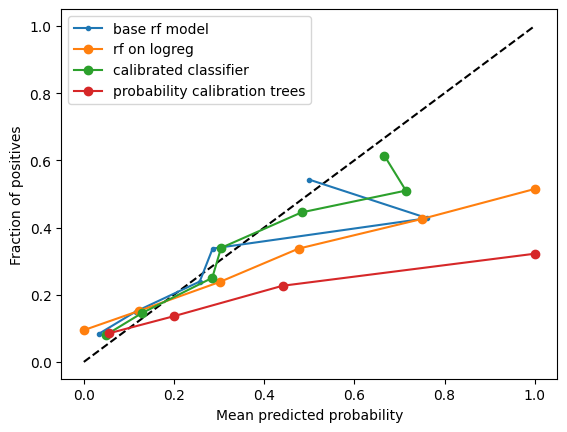

In [33]:
#добавим к графику калибровку на деревьях

fig, ax = plt.subplots()

ax.plot([0, 1], [0, 1], linestyle='--', color='black')

ax.plot(prob_true_rf, prob_pred_rf, marker='.', label='base rf model')
ax.plot(prob_true_lr, prob_pred_lr, marker='o', label='rf on logreg')
ax.plot(prob_true_calibrated, prob_pred_calibrated, marker='o', label='calibrated classifier')  
ax.plot(dt_prob_pred, dt_prob_true, marker='o', label='probability calibration trees')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
ax.legend()
plt.show()


### RegPlot

1) скорим пользователей
2) Сортируем по predict_proba
3) Разбиваем на 30 групп
4) Внутри каждой группы считаем среднюю предсказанную вероятность 
5) Внутри каждой группы считаем пропорцию дефолтников ко всем попавшим в эту группу
6) По оси Х откладываем значения полученные в пункте 4, а по оси Y откладываем значения из пункта 5
7) Повторяем для остальных алгоритмов

In [34]:
# Готовим данные для построения графика и расчета Expected Calibration Error (ECE)
# Для этого воспользуемся функцией give_ece_data
# Посчитаем ECE для логрега

bins = 30
predicted_bins,actual_counters,counters = give_ece_data(y_prob_lr.reshape((-1)),bins,all_new['60_6mob'].values)
lr_df = pd.DataFrame({'predicted':predicted_bins,'actual':actual_counters})

ece = 0
for i in range(bins):
    ece +=  counters[i]*np.abs((predicted_bins[i] - actual_counters[i]))
ece /= len(boosting_model.predict_proba(all_new.drop(['60_6mob'],axis=1))[:,1])
print(ece)

0.06681304790109444


In [35]:
# Посчитаем ECE для калибровки на деревьях

bins = 30
predicted_bins,actual_counters,counters = give_ece_data(predicts_calibrated.reshape((-1)),bins,all_new['60_6mob'].values)
check = pd.DataFrame({'predicted':predicted_bins,'actual':actual_counters})

ece = 0
for i in range(bins):
    ece +=  counters[i]*np.abs((predicted_bins[i] - actual_counters[i]))
ece /= len(boosting_model.predict_proba(all_new.drop(['60_6mob'],axis=1))[:,1])
print(ece)

0.07442602195929009


In [36]:
# Посчитаем ECE для калиброванного бустинга

bins = 30
predicted_bins,actual_counters,counters = give_ece_data(y_prob_calibrated.reshape((-1)),bins,all_new['60_6mob'].values)
calibrated_rf = pd.DataFrame({'predicted':predicted_bins,'actual':actual_counters})

ece = 0
for i in range(bins):
    ece +=  counters[i]*np.abs((predicted_bins[i] - actual_counters[i]))
ece /= len(boosting_model.predict_proba(all_new.drop(['60_6mob'],axis=1))[:,1])
print(ece)

0.04041905833969204


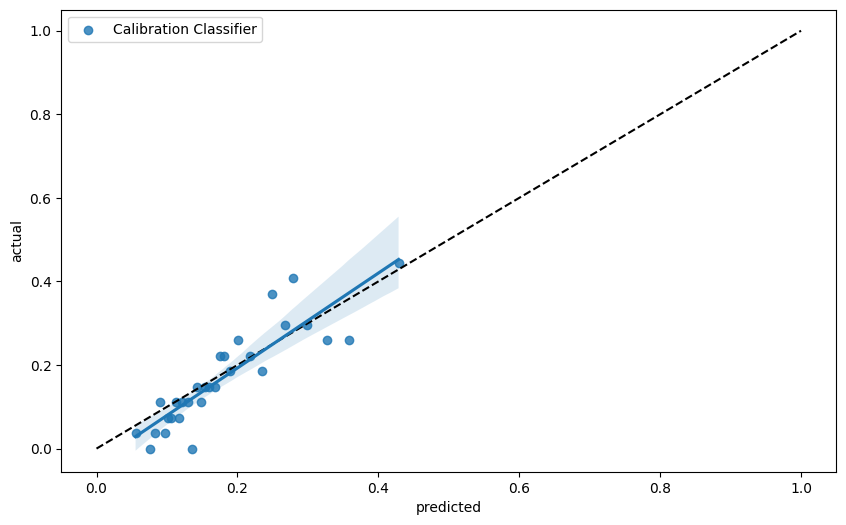

In [39]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot([0, 1], [0, 1], linestyle='--', color='black')
# sns.regplot(x='predicted', y='actual', data=check, label='probability calibration trees')
# sns.regplot(x='predicted', y='actual', data=lr_df, label='LogReg')
sns.regplot(x='predicted', y='actual', data=calibrated_rf, label='Calibration Classifier')
# ax.set(ylabel='y', xlabel='x')
ax.legend()
plt.show()